# Vectorization
<b> IST 736 - Text Mining - Homework 2 <br>
<b> Emilio Ramos Monzalvo - eramosmo@syr.edu - 10/18/2021

In this assignment, you will vectorize the data that you collected in HW1. Because the goal is to identify the public sentiment toward AI on social media, you need to think about what vectorization options, regarding both what to count and how to count, would be the best for this goal. Make sure to explain the decisions you made during the vectorization process, e.g., if you removed stopwords and why.<br>

Write a report to include the following information:
1. Briefly recap how you collected the data.
2. Describe your vectorization choices and corresponding result. For example, if you chose to do stemming, how did the vocabulary size change after stemming? Did the stemming eliminate important linguistic information that you'd rather keep, or not?
3. Conclude with the best vectorization option(s).

Your report should provide sufficient information for others to replicate what you did. Submit your report with your original data file and the vectors from your best vectorization options.

## Introduction

### Problem Statement

Artificial Intelligence (AI) is an extraordinary field that can do wonders to society by making it easier for a population to be understood through Social Media, but it can also cause harm as shown in the 2016 United States Presidential Election where a candidate used it to target individuals with propaganda. People who are not familiar with it and its applications can have a misunderstood perception on its applications and capabilities as Hollywood has created films where an AI algorithm can take over the world. Most recently, the Looney Toons cartoon with Basketball Star Lebron James, showed an algorithm learning how to play basketball in order to beat Lebron. Realistic or far fetched, the attitude of a population towards AI can help determine what its focus can be in the future. In order to find the population's opinion, the study uses Social Media platforms, mainly Twitter, to get recent comments about the topic of AI.

It is a common problem in Text Mining is trying to identify a sentiment on a particular subject. This area is known as Sentiment Analysis which has become quite popular due to its large set of applications. Some applications include understanding customer reviews or even analyzing the population sentiment to COVID-19. Consequently, there are a multitude of approaches and tools one can use to complete a Sentiment Analysis problem statement like this one. 

Before any sentiment analysis can be done, the text, in this case tweets, need to be processed and standarized in a way that does we only lose minimal information and maximize the importance of words that contain the most sentiment. I.e., given a sentence, the action and adverb are more likely to have information about the sentiment rather than the noun or mention in a tweet. Therefore, we would remove mentions and stopwords which do not add value to our model.

## Analysis and Models

### Notebook Configuration

In [4]:
%load_ext autotime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import json
import tweepy

import warnings
warnings.filterwarnings("ignore")

import nltk
import spacy
nlp = spacy.load("en_core_web_sm") # Get Spacy English Language

path = 'C:\\Users\\ramos\\OneDrive\\Documents\\SyracuseUniversity\\9th_Quarter\\IST736\\Homework\\'

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


### About the Data

<b> Source: https://developer.twitter.com/en/docs/twitter-api/tools-and-libraries </b>

The data was pulled using the free API provided by Twitter where one can write a query to match tweets to a specific topic of choice. The API allows for one to pull the most recent tweets from the last 30 days. The data is constantly pulled throughout the week since there is a maximum of 2000 tweets to be pulled per day. Nonetheless, there is a total of 11979 tweets being used for this analysis.

The query fed into the API was restricted the search to the English Language and a date no longer than 30 days from today, October 30th, 2021. The query is looking for any tweet that contains the characters 'AI' or 'Artificial Intelligence' separated by a space or end of tweet and/or start of tweet. The only field kept from the search was the text field from the tweet. No other field like user, location, favorite, or retweet was considered in order to simplify the analysis to only text data, and to preserve user anonimity. The location, or geo-code, was not included in the query since it is not the analysis is not limited to a certain population.

In [2]:
##### Get NEW Tweets about AI
f_twitter_cred = open(path + '\\HWData\\twitter.json')
twitter_cred = json.load(f_twitter_cred)

auth = tweepy.OAuthHandler(twitter_cred['api_key'], twitter_cred['api_secret_key'])
auth.set_access_token(twitter_cred['access_token'], twitter_cred['access_token_secret'])

api = tweepy.API(auth, wait_on_rate_limit=True)

max_tweets = 10000
toDate=pd.to_datetime(np.datetime64('today'))
fromDate=pd.to_datetime(np.datetime64('today')-np.timedelta64(30, 'D'))

warnings.filterwarnings("ignore")

searched_tweets = tweepy.Cursor(api.search_30_day, label='IST736TextMining', query='(Artificial Intelligence OR AI) -RT lang:en',  fromDate=fromDate.strftime('%Y%m%d%H%m'), toDate=toDate.strftime('%Y%m%d%H%m')).items(max_tweets)

tweets = []
try:
    for tweet in searched_tweets:
        tweets.append(tweet.text)
except:
    print('Limit Exceeded')

df = pd.DataFrame(tweets, columns=['tweet']) # Convert to Data Frame

print('Read in {} New Tweets.'.format(len(tweets)))

##### Append new Tweets to Old Tweets if they exist
tweets_f = glob.glob(path + '\\HWData\\tweets.csv')

if len(tweets_f) > 0:
    
    # Append New Tweets and Drop Duplicates
    if len(df) > 0:
        df = pd.concat([df, pd.read_csv(path + '\\HWData\\tweets.csv')]).drop_duplicates(['tweet'])
        df = df.reset_index(drop=True)
        
        # Save New Tweets
        df.to_csv(path + '\\HWData\\tweets.csv', index=False) # Save to CSV File

    else:
        df = pd.read_csv(path + '\\HWData\\tweets.csv')
    
print('Data Frame has {} Tweets.'.format(len(df)))

df.head()

Limit Exceeded
Read in 3000 New Tweets.
Data Frame has 11979 Tweets.


,tweet
0,There actually is AI for this??? What the hell...
1,'Let that sink in': Rep. Dan Crenshaw slams $4...
2,@ai_curio_bot botprompt: https://t.co/pXkQQWcOHj
3,"@ai_uehara_ex Good morning, honey"
4,@ai_curio_bot botprompt: An unimaginable quant...


### Processing Tweets

As mentioned above, the tweets need to be processed accordingly to extract as much information as possible regarding the sentiment of the tweets. In order to do so, the steps taken are listed below:
1. Tokenizing
2. Remove unwanted words and punctuation.
3. Lemmatize and Stemming
4. Vectorize

#### Tokenize

NLTK package provides a simple and reliable tokenizer meant specifically for tweets. It takes into account the emojis, retweets and other Twitter specific patterns that make it easier for a developer to use when processing tweets.

In [5]:
# Define Tweet Tokenizer
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

In [6]:
# Tokenize List of Tweets
tokens = [tt.tokenize(tweet) for tweet in df['tweet'].values]
print(tokens[:10])

[['There', 'actually', 'is', 'AI', 'for', 'this', '?', '?', '?', 'What', 'the', 'hell', 'Kaga', 'https://t.co/2ujn09QgeL'], ["'", 'Let', 'that', 'sink', 'in', "'", ':', 'Rep', '.', 'Dan', 'Crenshaw', 'slams', '$', '450,000', 'per', 'person', 'payout', 'to', 'families', 'who', 'illegally', 'crossed', 'border', 'whi', '…', 'https://t.co/PmVxlKzakt'], ['@ai_curio_bot', 'botprompt', ':', 'https://t.co/pXkQQWcOHj'], ['@ai_uehara_ex', 'Good', 'morning', ',', 'honey'], ['@ai_curio_bot', 'botprompt', ':', 'An', 'unimaginable', 'quantity', 'of', 'cheese'], ['@severitis', 'Glad', 'you', 'like', '!', "We've", 'been', 'working', 'on', 'them', 'for', 'a', 'few', 'months', '.', 'They', 'have', 'a', 'whole', 'delivery', 'system', 'and', 'unique', '…', 'https://t.co/EETiAjTXsJ'], ['@robertjoseph', '@RaynaRambling', 'Are', 'we', 'going', 'to', 'delegate', 'film', ',', 'book', 'and', 'music', 'critiques', 'to', 'AI', 'as', 'well', '?'], ['#Facebook', 'AI', 'what', 'crack', 'are', 'you', 'smoking', '?', 

#### Remove unwanted words and punctuation 

Tweets are likely to contain mentions and URLs attached. These values are likely to be unique to the tweets and will not provide insight on the sentiment of a tweet. The URLs might be a picture or a link to a website which might have information relevant to the analysis, but this would require other techniques like computer vision or web scrapping that are out of scope of the analysis. 

Since the sentiment is the goal of the analysis, stopwords are not likely to contain additional information since they can exist in every tweet like the word 'a' on a bag of word model. Similarly, punctuation's benefit on a bag of words model is likely to be non-existant.

Finally, since the query used to search for tweets looks for tweets containing the words AI and/or Artificial Intelligence, then every tweet has to contain the words which prevents us from using it to gain information from the tweets. 

In [41]:
import re
from nltk.corpus import stopwords
stopWords = stopwords.words('english')

def preprocess_text(doc):
    """
    Function used to preprocess text into a standarized format
    """
    
    tweet_tokenized = []
    for tkn in doc:
        
        ### Remove Mentions and URLs
        tkn_processed = re.sub(r"(?:\@|https?\://)\S+", "", tkn)
        
        ### Standarize Text
        # lower case
        tkn_processed = tkn_processed.lower()
        # remove digits
        tkn_processed = re.sub(r'\d+', '', tkn_processed)
        # remove punctuation and special chars
        tkn_processed = re.sub(r'[^\w\s]+', ' ', tkn_processed)
        # strip whitespace
        tkn_processed = tkn_processed.strip()
        
        ### Remove Stop Words
        if tkn_processed in stopWords:
            continue
            
        # If word is not empy, then add to document token list
        if tkn_processed != '':
            tweet_tokenized.append(tkn_processed)
    
    ## Remove AI and Artificial Intelligence
    tweet_tokenized = ' '.join(tweet_tokenized).replace('artificial intelligence', '').replace('ai', '').strip().split(' ')
    tweet_tokenized = [i for i in tweet_tokenized if i]
    
    return tweet_tokenized

In [42]:
tokens_processed = [preprocess_text(doc) for doc in tokens]

#### Lemmatizing and Stemming

Due to the large variations of word's context, tense and plurality, a bag of words model works best if known variations of a word are stanarized as one. For example if one tweet includes the word 'great' to describe AI, we would want other tweets use 'greatness' to be grouped in a similar category since they are both describing AI with the same sentiment.

Therefore, the words are first lemmatized and then stemmed to reduce the variations of words and count of unique words. Lemmatization is done first since a word can have multiple meanings, so extracting it using the context of the tweet is important before a word is stemmed which can remove some context of the tweet. For Lemmatization, the Word Net Lemmatizer is used as it is a standard lemmatizer in NLP while the Snoball Stemmer is preferred for Stemming since it is a superior version to the Porter Stemmer.

In [50]:
# Define Lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
lmt = WordNetLemmatizer()

# Lemmatize the tokens.
lemm_tokens = [[lmt.lemmatize(tkn) for tkn in doc] for doc in tokens_processed]

# Print Some Stemmed Docs
print(lemm_tokens[:5])

[['actually', 'hell', 'kaga'], ['let', 'sink', 'rep', 'dan', 'crenshaw', 'slam', 'per', 'person', 'payout', 'family', 'illegally', 'crossed', 'border', 'whi'], ['botprompt'], ['good', 'morning', 'honey'], ['botprompt', 'unimaginable', 'quantity', 'cheese']]


In [51]:
# Define Stemmer
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

# Lemmatize the tokens.
stem_tokens = [[stemmer.stem(tkn) for tkn in doc] for doc in lemm_tokens]

# Print Some Stemmed Docs
print(stem_tokens[:5])

[['actual', 'hell', 'kaga'], ['let', 'sink', 'rep', 'dan', 'crenshaw', 'slam', 'per', 'person', 'payout', 'famili', 'illeg', 'cross', 'border', 'whi'], ['botprompt'], ['good', 'morn', 'honey'], ['botprompt', 'unimagin', 'quantiti', 'chees']]


#### Before and After Text Processing

In order to visualize the effects of the text processing, the word count and character count can be visualized to see how much each step reduces them. 

In [52]:
processing_stages = ['tokenized', 'standarized', 'lemmatized', 'stemmed']

In [53]:
df['tokenized'] = tokens
df['standarized'] = tokens_processed
df['lemmatized'] = lemm_tokens
df['stemmed'] = stem_tokens

In [82]:
unique_tkns = {}
for stage in processing_stages:
    unique_tkns[stage] = len(np.unique(df[stage].sum()))
    df['word_count_{}'.format(stage)]  = df[stage].apply(len)

##### Unique Word Count

After each step in the processing, there should be a reduction in unique words. If this is not the case, then the processes migh have some error which creates more unique words. It is a safety check before moving on to vectorization and modeling. As shown below, the biggest drop comes from the standarization stage, but there is still a consitent drop of unique words after each processing stage.

<AxesSubplot:xlabel='stage', ylabel='unique_word_count'>

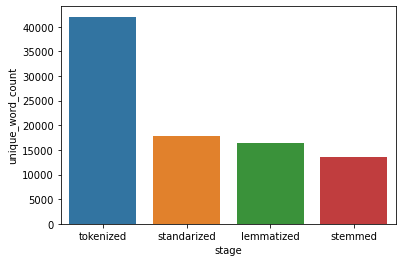

In [84]:
unique_tkns_df = pd.DataFrame.from_dict(unique_tkns, orient='index', columns=['unique_word_count']).reset_index(drop=False).rename(columns={'index':'stage'})
sns.barplot(data=unique_tkns_df,
            y='unique_word_count', x='stage')

In [89]:
unique_tkns_df

,stage,unique_word_count
0,tokenized,42036
1,standarized,17923
2,lemmatized,16427
3,stemmed,13590


##### Word Count
The biggest lead in word count reduction happens after the Standarization stage. The tokenizer mainly splits the data based on white space, so we get a raw word count of the tweet.

0 tokenized
1 standarized
2 lemmatized
3 stemmed


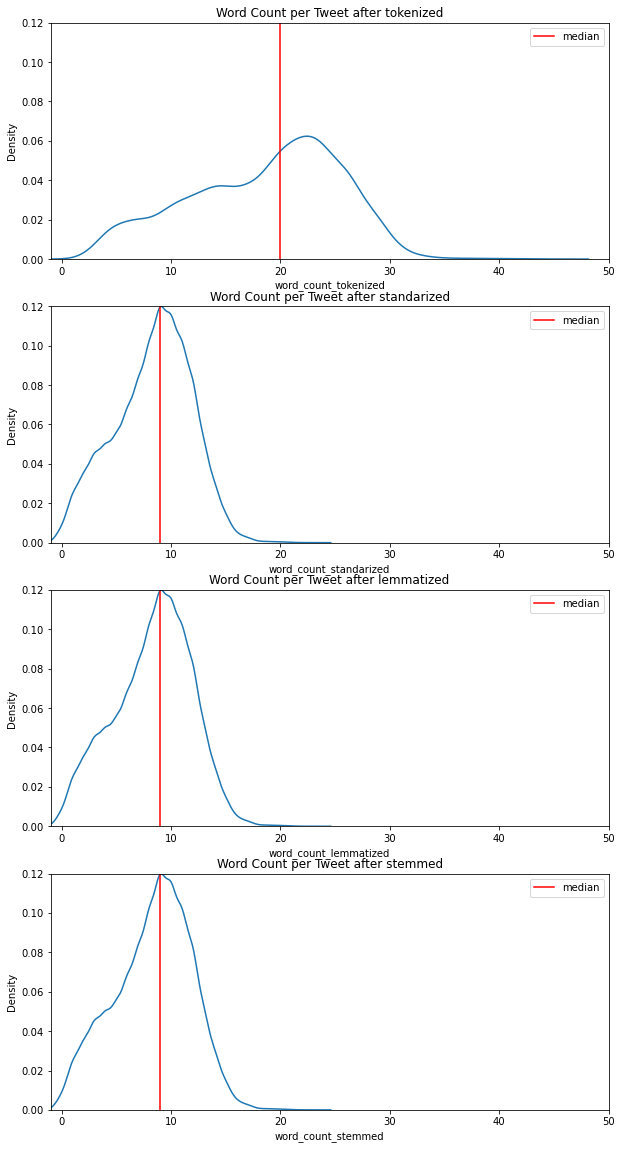

In [88]:
plt.figure(figsize=(10, 20))
for i, stage in enumerate(processing_stages):
    print(i, stage)
    plt.subplot(411+i)
    ax = sns.kdeplot(data=df, x='word_count_' + stage)
    ax.plot([df['word_count_' + stage].median(), df['word_count_' + stage].median()], [0, .12], color='red', label='median')
    plt.xlim(-1, 50)
    plt.ylim(0, .12)
    plt.title('Word Count per Tweet after {}'.format(stage))
    plt.legend()

##### Remove Non-Usable Tweets

Due to the small count of words on some tweets, their likelyhood of returning any sentiment is low since most of the context is taken out of the tweets. Therefore, tweets with less than 3 values left are taken out of the dataframe.

In [207]:
df = df.loc[df['word_count_stemmed'] > 3].reset_index(drop=True)

#### Vectorize

The vectorization of a document is a crucial step to modeling in Sentiment Analysis due to the power to reduce or increase the importance of words or tokens. The main idea of vectorization is to create a MxN matrix, X, where N is the number of unique words and M is the number of tweets where the value X(i,j) represents a words value to a tweets. The value could be whether it exists in the tweet or not, the frequency of the word in the tweet, and even some normalized version of the word's relationship to the tweet.

Since a tweet after the processing stages has a median count of nine words, the frequency of a word in a tweet is likely to always be 0 if we have a total of 13590 unique tokens. Therefore, the matrix will be extremly sparse and the frequency of a token in a tweet will likely not go past 1 since a word repeating itself in a tweet is also not likely.

Consequently, the TD-IDF Vectorizer and the Count Vectorizer were chosen to be compared against each other to see which one is more effective than the other in the Sentiment Analysis of tweets. The TF-IDF provides an extra layer from the frequency vectorizer since it normalizes the frequency of a word in the whole list of tweets. I.e., if a word exists in multiple tweets, the word will become less important and the unique words will have more authority in the models. There will also be a list of 50 tweets left out of the fitting of the vectorizer which will later be used to compare the results in a word cloud.

In [208]:
def dummy(doc):
    return doc

test_n = 50

In [233]:
# Define Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(
        analyzer='word',
        tokenizer=dummy,
        preprocessor=dummy,
        max_features=1000
    ) 

# Apply Vectorizer on Token Lists
cv_vect = cv.fit_transform(df['stemmed'][:-test_n]) 
cv_vect_test = cv.transform(df['stemmed'][-test_n:])

In [234]:
# Define TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
        analyzer='word',
        tokenizer=dummy,
        preprocessor=dummy,
        max_features=1000
    ) 

# Apply Vectorizer on Token Lists
tfidf_vect = tfidf.fit_transform(df['stemmed'][:-test_n])
tfidf_vect_test = tfidf.transform(df['stemmed'][-test_n:])

### Modeling

In order to compare the two types of vectorizers, the two vectors were fed into the same K-Means clustering model with K equal to three clusters. The reason two clusters were chosen is to see if the cluster can identify extremes sentiments on tweets regarding AI. Once the models are trained using the two vectors, they will be compared based on the classification of 100 tweets that were left out of the training set.

Prior to the clustering, the Sentiment Analyzer tool, VADER, from NLTK was used to produce sentiment results on the test set of tweets to see the neutral, positive and negative tweets were labeled separated correctly in the clustering. This will provide a reference of how well each vectorizer worked to split up the tweets based on sentiment. After VADER was applied, there was an even split of 51% of tweets with a positive sentiment and 49% with a negative sentiment. The test set has 29 positive and 21 negative tweets.

#### Vader Sentiment Analyzer

In [225]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
vader_res_pos = []
vader_res_neg = []
vader_res_neu = []
vader_res_comp = []
for sentence in df['tweet']:
    ss = sid.polarity_scores(sentence)
    vader_res_neg.append(ss['neg'])
    vader_res_pos.append(ss['pos'])
    vader_res_neu.append(ss['neu'])
    vader_res_comp.append(ss['compound'])
    
df['vader_neg'] = vader_res_neg
df['vader_pos'] = vader_res_pos
df['vader_comp'] = vader_res_comp
df['vader_res'] = ['pos' if x>0 else 'neg'  for x in df['vader_comp'].values]

In [226]:
df['vader_res'].value_counts(normalize=True)

pos    0.508906
neg    0.491094
Name: vader_res, dtype: float64

In [227]:
df['vader_res'].value_counts()

pos    5400
neg    5211
Name: vader_res, dtype: int64

In [228]:
df.iloc[-test_n:]['vader_res'].value_counts()

pos    29
neg    21
Name: vader_res, dtype: int64

In [229]:
len(df)

10611

#### KMeans Clustering

In [230]:
from sklearn.cluster import KMeans
n_clusters = 2

In [235]:
# Define Count Vect KMeans and Train
cv_kmeans = KMeans(n_clusters=n_clusters).fit(cv_vect)

# Predict Cluster on Test Data and Train
df['cv_label'] = cv_kmeans.predict(cv_vect).tolist() + cv_kmeans.predict(cv_vect_test).tolist()
df['cv_label'].value_counts()

0    9837
1     774
Name: cv_label, dtype: int64

In [236]:
# Define TF-IDF Vect KMeans
tfidf_kmeans = KMeans(n_clusters=n_clusters).fit(tfidf_vect)

# Predict Cluster on Test Data and Train
df['tfidf_label'] = tfidf_kmeans.predict(tfidf_vect).tolist() + tfidf_kmeans.predict(tfidf_vect_test).tolist()
df['tfidf_label'].value_counts()

0    10402
1      209
Name: tfidf_label, dtype: int64

## Results

To compare the results of the two Vectorizers, the results from the VADER sentiment analyzer were used as a reference. Thus, the test set of tweets were used as a reference to see if the KMeans cluster separated positive and negative tweets correctly or not. Then, the CV and TFIDF vectorizers can be compared using their accuracy to separate the two types of tweets.

### Cluster Results

According the prediction of the clustering by each of the KMeans model used, the only Count Vectorizer was able to separate more tweets than the TF-IDF vectorizer model. The TF-IDF only returned a total of 209 values in a separate cluster unlike the Count Vectorizer model which returned 774 tweets in a separate cluster. 

In [269]:
clus_res_cv = df.groupby(['cv_label']).head(10)[['stemmed', 'cv_label']]
clus_res_cv['new_index']  = clus_res_cv.groupby('cv_label').cumcount()
clus_res_cv.set_index(['new_index', 'cv_label']).unstack()

stemmed  \
cv_label                                                   0   
new_index                                                      
0          [let, sink, rep, dan, crenshaw, slam, per, per...   
1                     [botprompt, unimagin, quantiti, chees]   
2          [glad, like, we, ve, work, month, whole, deliv...   
3              [go, deleg, film, book, music, critiqu, well]   
4          [facebook, crack, smoke, obvious, communiti, s...   
5          [consid, technologist, look, someth, typic, de...   
6           [hurri, premium, domnnam, forsal, web, metavers]   
7                       [late, ml, wave, go, time, blockchn]   
8          [welcom, aboard, civ, trn, make, proud, civ, f...   
9          [sold, agld, price, usdt, profit, use, cryptos...   

                                                              
cv_label                                                   1  
new_index                                                     
0          [chill, je, lui, dit, shut, goy, it, s, place,...  
1          [leak, photo, may, show, meta, s, much, rumor,...  
2          [there, s, probabl, sort, limit, could, persis...  
3          [don, t, follow, it, s, good, time, ad, restor...  
4          [anoth, feather, googl, servic, s, cap, look, ...  
5          [mcdonald, s, ibm, drive, thru, partnership, s...  
6          [yes, make, total, sens, that, s, whole, point...  
7          [self, learn, especi, deep, learn, realli, tri...  
8          [memori, someon, who, s, pass, away, remn, bea...  
9          [work, franchis, sale, repres, inform, she, s,...

In [259]:
clus_res_tfidf = df.groupby(['tfidf_label']).head(10)[['stemmed', 'tfidf_label']]
clus_res_tfidf['new_index']  = clus_res_tfidf.groupby('tfidf_label').cumcount()
clus_res_tfidf.set_index(['new_index', 'tfidf_label']).unstack()

stemmed  \
tfidf_label                                                  0   
new_index                                                        
0            [let, sink, rep, dan, crenshaw, slam, per, per...   
1                       [botprompt, unimagin, quantiti, chees]   
2            [glad, like, we, ve, work, month, whole, deliv...   
3                [go, deleg, film, book, music, critiqu, well]   
4            [facebook, crack, smoke, obvious, communiti, s...   
5            [consid, technologist, look, someth, typic, de...   
6             [hurri, premium, domnnam, forsal, web, metavers]   
7            [chill, je, lui, dit, shut, goy, it, s, place,...   
8                         [late, ml, wave, go, time, blockchn]   
9            [welcom, aboard, civ, trn, make, proud, civ, f...   

                                                                
tfidf_label                                                  1  
new_index                                                       
0            [don, t, follow, it, s, good, time, ad, restor...  
1            [think, result, ad, restor, pictur, creat, art...  
2            [hey, ad, restor, pictur, creat, art, remov, b...  
3            [hope, like, ad, restor, pictur, creat, art, r...  
4            [best, ad, restor, pictur, creat, art, remov, ...  
5            [pleasur, help, ad, restor, pictur, creat, art...  
6            [cours, nice, help, ad, restor, pictur, creat,...  
7            [like, result, ad, restor, pictur, creat, art,...  
8            [sure, hope, like, ad, restor, pictur, creat, ...  
9            [color, use, ad, restor, pictur, creat, art, r...

The tweets on separate cluster identified by the TF-IDF KMeans cluster shows how the cluster separated them by the use of words relating to pictures like Art, Restoring and Creating. Therefore, the KMeans model failed to separate by sentiment, but it was able to find a patter to create two clusters. The TF-IDF vectorized cluster failed to find as many tweets to fall onto the smaller cluster while the Count Vectorizer on the other hand separated more even if this was not the intent of the study. The Count Vectorizer did not return a kind of pattern seen on the smaller cluster like the TF-IDF. The tokens found on the tweets are more generic than the TF-IDF cluster. Nonetheless, the study's purpose was to identify the sentiment of the tweets which it failed to do so. The study should focus on using a supervised approach to get the sentiment of tweets on future approaches rather than using a clustering method to separate tweets with a bag of word model.

### Test Set Results

The test set also reveal how none of the vectorizer Kmeans models were  able to separate tweets based on sentiment. The results are inconclusive as to which vectorizer works best since KMeans is unable to create two large clusters with sentiments in hand. The test resuls only show how the Count Vectorizer was able to separate two tweets on the test set while the TF-IDF did not. It however does not mean that the TF-IDF vectorizer performed better than the Count Vectorizer. It just means there was more variability in the test set regarding the pattern found by the Count Vectorizer KMeans model.

In [266]:
# Get Data Frame of the Test Set
test_df = df.iloc[-test_n:]

#### Count Vectorizer Results

In [273]:
test_df.groupby(['cv_label', 'vader_res']).size().unstack()

vader_res,neg,pos
cv_label,,
0,19,27
1,2,2


In [271]:
clus_res_cv = test_df.groupby(['cv_label']).head(10)[['stemmed', 'cv_label']]
clus_res_cv['new_index']  = clus_res_cv.groupby('cv_label').cumcount()
clus_res_cv.set_index(['new_index', 'cv_label']).unstack()

stemmed  \
cv_label                                                   0   
new_index                                                      
0          [vlog, good, sourc, incom, creator, good, sell...   
1          [growth, experienc, today, core, purpos, lead,...   
2          [leadership, follow, mission, connect, peopl, ...   
3          [navig, trap, facebook, social, network, platf...   
4          [chanc, vw, dieselg, like, defeat, devic, use,...   
5          [growth, face, valu, noth, wrong, goal, fact, ...   
6          [facebook, exist, connect, everi, person, worl...   
7          [success, datasci, enterpris, analyt, visual, ...   
8                                [possess, gay, ghost, haha]   
9          [leadership, geniouxmg, learn, busi, innov, vi...   

                                                              
cv_label                                                   1  
new_index                                                     
0          [test, get, fire, that, s, real, cultur, exper...  
1          [cool, use, cradlepoint, s, iot, solut, singap...  
2                [cybersecur, blind, spot, s, inher, vulner]  
3          [ian, bremmer, delet, concept, around, sinc, a...  
4                                                        NaN  
5                                                        NaN  
6                                                        NaN  
7                                                        NaN  
8                                                        NaN  
9                                                        NaN

#### TF-IDF Vectorizer Results

In [238]:
test_df.groupby(['tfidf_label', 'vader_res']).size().unstack()

vader_res,neg,pos
tfidf_label,,
0,21,29


In [274]:
clus_res_tfidf = test_df.groupby(['tfidf_label']).head(10)[['stemmed', 'tfidf_label']]
clus_res_tfidf['new_index']  = clus_res_tfidf.groupby('tfidf_label').cumcount()
clus_res_tfidf.set_index(['new_index', 'tfidf_label']).unstack()

,stemmed
tfidf_label,0
new_index,
0,"[vlog, good, sourc, incom, creator, good, sell..."
1,"[growth, experienc, today, core, purpos, lead,..."
2,"[leadership, follow, mission, connect, peopl, ..."
3,"[navig, trap, facebook, social, network, platf..."
4,"[chanc, vw, dieselg, like, defeat, devic, use,..."
5,"[growth, face, valu, noth, wrong, goal, fact, ..."
6,"[facebook, exist, connect, everi, person, worl..."
7,"[success, datasci, enterpris, analyt, visual, ..."


## Conclusions

The public sentiment towards AI is showing to be an unlikely value to be extracted from tweets without the use of Supervised Learning techniques. The KMeans algorithm chosen to create clusters based on different vectorization algorithms returned no conclusive results as to the sentiment towards Artificial Intelligence, but it did return a favorable outcome towards the TF-IDF vectorizer. The TF-IDF vectorizer provides a normalized version of the token frequency which can lead to better results when using tweets.

In order to produce better results, a Supervised Method should be used on tweets since the accuracy of unsupervised methods on sparse data is unreliable. The Sentiment of AI will remain a mystery until a labeled and reliable dataset is picked up to train a model. Even using Sentiment Analyzer techniques like VADER have a limitation compared to the use of the human intellect to manually label the sentiment of a tweet. Nonetheless, as more is learned about the types of tools available to perform sentiment analysis on tweets, AI's impact on society will likely be revealed.